In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [24]:
# Завантаження даних 
data = pd.read_csv(r'cheese_data.csv')

In [25]:
# Виведення колонок
data.columns

Index(['CheeseId', 'ManufacturerProvCode', 'ManufacturingTypeEn',
       'MoisturePercent', 'FlavourEn', 'CharacteristicsEn', 'Organic',
       'CategoryTypeEn', 'MilkTypeEn', 'MilkTreatmentTypeEn', 'RindTypeEn',
       'CheeseName', 'FatLevel'],
      dtype='object')

In [26]:
# Візуалізація даних
data.head(5)

,CheeseId,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel
0,228,NB,Farmstead,47.0,"Sharp, lactic",Uncooked,0,Firm Cheese,Ewe,Raw Milk,Washed Rind,Sieur de Duplessis (Le),lower fat
1,242,NB,Farmstead,47.9,"Sharp, lactic, lightly caramelized",Uncooked,0,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Tomme Le Champ Doré,lower fat
2,301,ON,Industrial,54.0,"Mild, tangy, and fruity","Pressed and cooked cheese, pasta filata, inter...",0,Firm Cheese,Cow,Pasteurized,NaN,Provolone Sette Fette (Tre-Stelle),lower fat
3,303,NB,Farmstead,47.0,Sharp with fruity notes and a hint of wild honey,NaN,0,Veined Cheeses,Cow,Raw Milk,NaN,Geai Bleu (Le),lower fat
4,319,NB,Farmstead,49.4,Softer taste,NaN,1,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Gamin (Le),lower fat


In [27]:
# Перевірка на наявність пропусків
print("Missing values before filling:")
print(data.isnull().sum())

Missing values before filling:
CheeseId                  0
ManufacturerProvCode      0
ManufacturingTypeEn       0
MoisturePercent          14
FlavourEn               241
CharacteristicsEn       399
Organic                   0
CategoryTypeEn           23
MilkTypeEn                1
MilkTreatmentTypeEn      65
RindTypeEn              321
CheeseName                0
FatLevel                  0
dtype: int64


In [28]:
# Заповнення числових NaN медіаною
for column in data.select_dtypes(include=[np.number]).columns:
    data[column].fillna(data[column].median(), inplace=True)

In [29]:
# Заповнення пропусків у категорійних колонках модою
for column in data.select_dtypes(include=['object']).columns:
    data[column].fillna(data[column].mode()[0], inplace=True)

In [30]:
# Перевірка після заповнення
print("\nMissing values after filling:")
print(data.isnull().sum())


Missing values after filling:
CheeseId                0
ManufacturerProvCode    0
ManufacturingTypeEn     0
MoisturePercent         0
FlavourEn               0
CharacteristicsEn       0
Organic                 0
CategoryTypeEn          0
MilkTypeEn              0
MilkTreatmentTypeEn     0
RindTypeEn              0
CheeseName              0
FatLevel                0
dtype: int64


In [31]:
# Встановлюємо CategoryTypeEn як таргет
target = 'CategoryTypeEn'
data[target] = LabelEncoder().fit_transform(data[target])

In [32]:
# Підготовка даних
data_encoded = pd.get_dummies(data.drop(columns=[target, 'CheeseId', 'CheeseName']), drop_first=True)
X = data_encoded
y = data[target]

In [33]:
# Нормалізація
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [34]:
# Розділення на тренувальні та тестові дані
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [35]:
# Налаштування параметрів та ініціалізація моделей
knn_params = {'n_neighbors': range(1, 11)}
svm_params = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]}

In [36]:
# k-Nearest Neighbors
grid_knn = GridSearchCV(KNeighborsClassifier(), knn_params, cv=3, scoring='accuracy')
grid_knn.fit(X_train, y_train)
best_knn = grid_knn.best_estimator_

# Support Vector Machine
grid_svm = GridSearchCV(SVC(), svm_params, cv=3, scoring='accuracy')
grid_svm.fit(X_train, y_train)
best_svm = grid_svm.best_estimator_

# Інші моделі
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42).fit(X_train, y_train),
    'Random Forest': RandomForestClassifier(random_state=42).fit(X_train, y_train),
    'AdaBoost': AdaBoostClassifier(random_state=42).fit(X_train, y_train),
    'kNN': best_knn,
    'SVM': best_svm
}

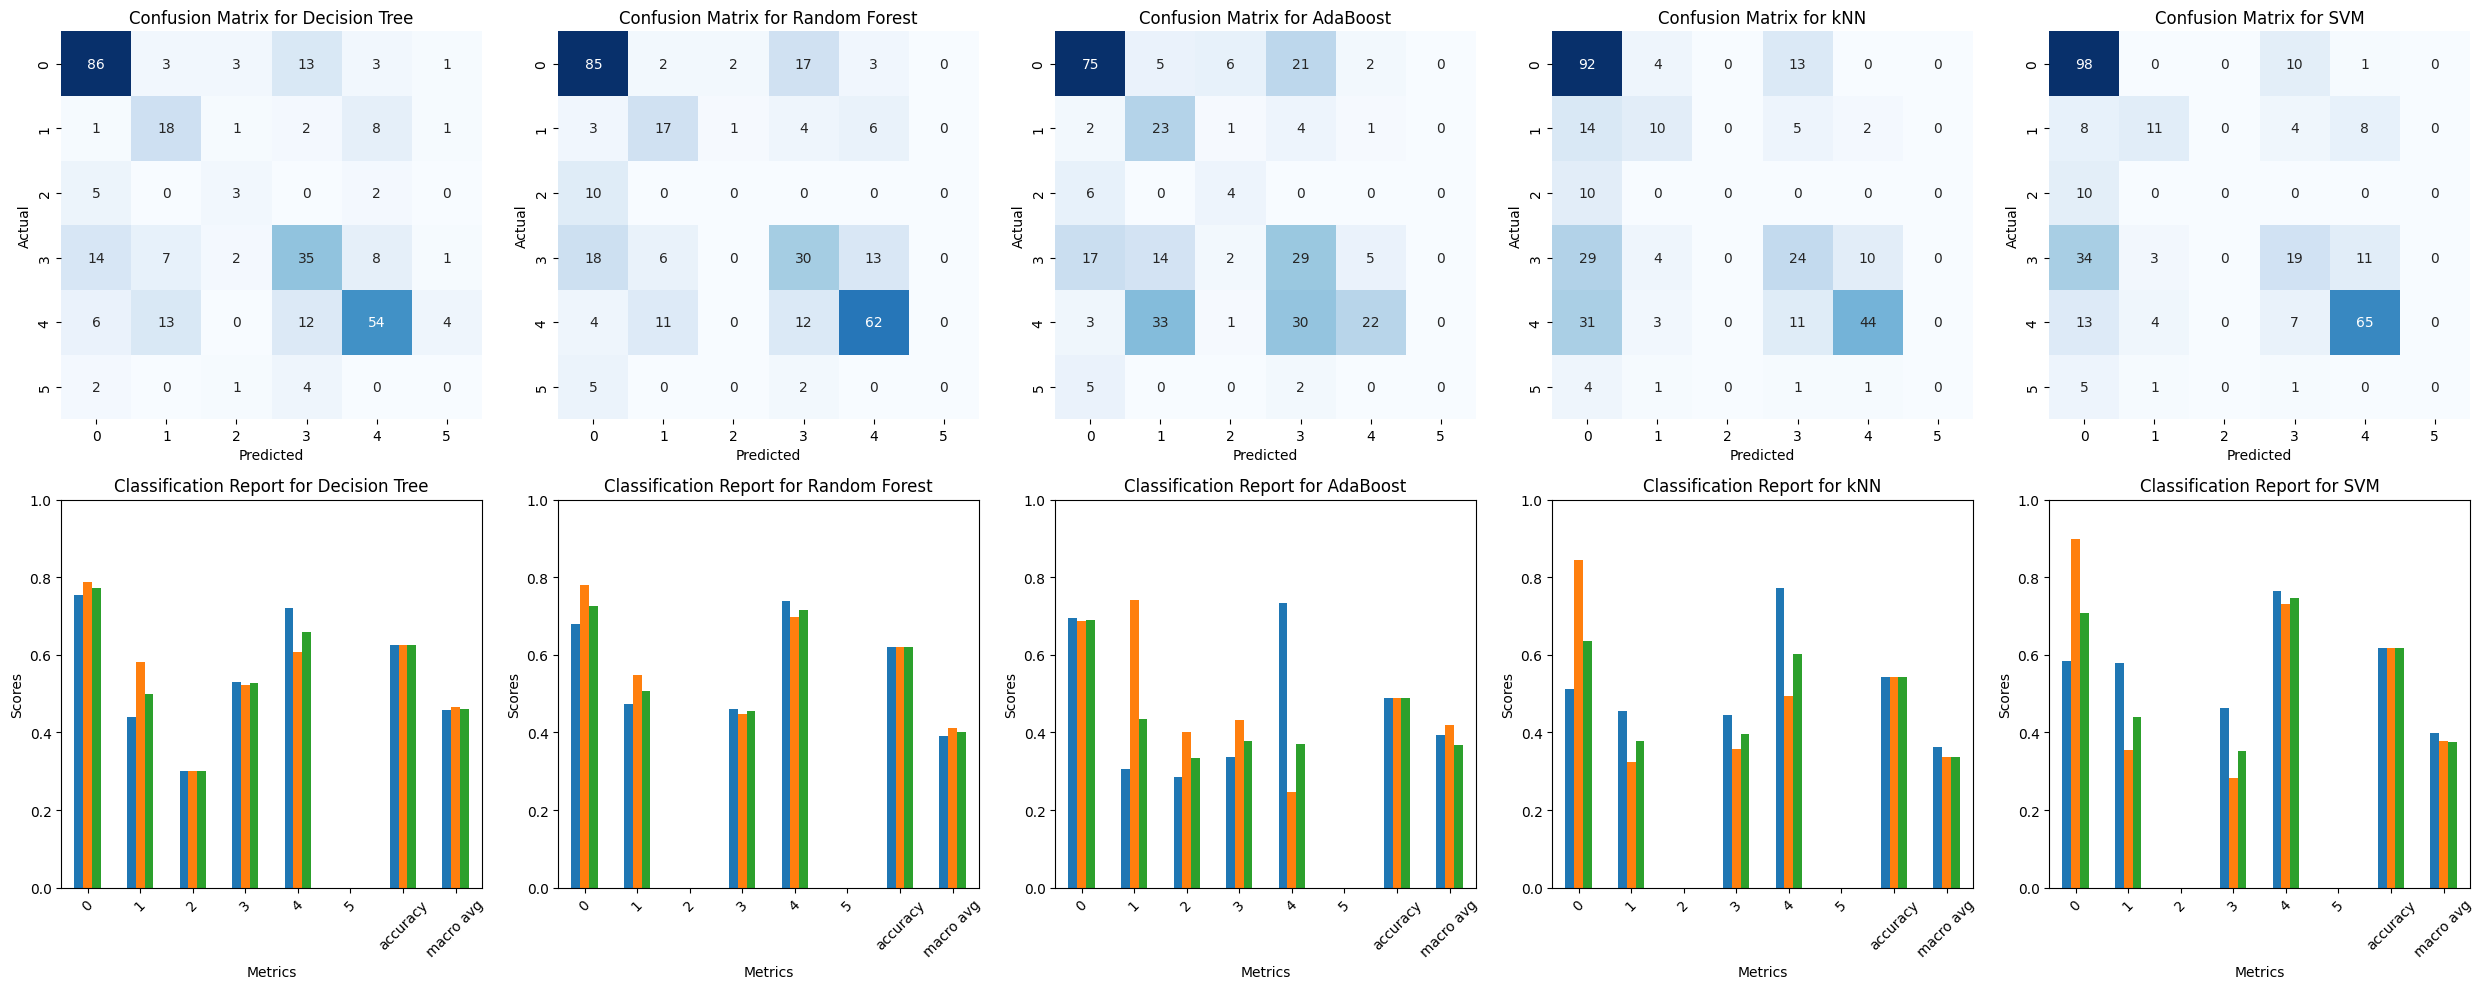

In [40]:
num_models = len(models)

fig, axes = plt.subplots(2, num_models, figsize=(5 * num_models, 10))

# Оцінка моделей і візуалізація в одному рядку
for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0, i])
    axes[0, i].set_title(f"Confusion Matrix for {name}")
    axes[0, i].set_xlabel("Predicted")
    axes[0, i].set_ylabel("Actual")
    
    # Classification Report у вигляді гістограм
    report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    report_df.iloc[:-1, :-1].plot(kind="bar", ylim=(0, 1), ax=axes[1, i], legend=False)
    axes[1, i].set_title(f"Classification Report for {name}")
    axes[1, i].set_xlabel("Metrics")
    axes[1, i].set_ylabel("Scores")
    axes[1, i].set_xticklabels(report_df.index[:-1], rotation=45)

plt.tight_layout()
plt.show()